In [1]:
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
teams_to_systems = json.load(open('team-to-submissions.json'))
datasets = {
    # dataset_name: (category, prefix, suffix)
    'pan24-generative-authorship-test-20240502-test': ('main', '', ''),
    'pan24-generative-authorship-test-b-20240506-test': ('cross-domain', '', '-cross-domain'),
    'pan24-generative-authorship-news-test-c-20240506-test': ('unicode-full', '', '-unicode-full'),
    'pan24-generative-authorship-news-test-d-20240506-test': ('unicode-half', '', '-unicode-half'),
    # 'pan24-generative-authorship-news-test-e-20240506-test': ('german', '', '-german'),          # German was mixed into main dataset
    'pan24-generative-authorship-news-test-f-20240514-test': ('paraphrase', '', '-paraphrase'),
    'pan24-generative-authorship-news-test-g-20240516-test': ('contrastive', '', ''),              # suffix already part of the name
    'pan24-generative-authorship-news-test-h-20240521-test': ('short', '', '-short'),
    'pan24-generative-authorship-eloquent-20240523-test': ('eloquent', 'eloquent-', ''),
}

df_ = []
df_micro_mean_ = []
evaluation_scores = json.load(open('evaluation-scores.json', 'r'))
for team, systems in teams_to_systems.items():
    for s in systems:
        row_base = {'system': s, 'team': team if team != 'baseline' else s}
        for d, (dname, pre, suff) in datasets.items():
            df_micro_mean_.append({
                **row_base,
                'category': dname,
                **{k:v for k, v in evaluation_scores[team].get(s, {}).get(d, {}).items() if k != '_sources'}
            })
            df_.extend(
                {
                    **row_base,
                    'dataset': ''.join((pre, src, suff)),
                    'category': dname,
                    **evaluation_scores[team][s][d]['_sources'][src]
                } for src in evaluation_scores[team].get(s, {}).get(d, {}).get('_sources', [])
            )

df_micro_mean_ = pd.DataFrame(df_micro_mean_).dropna()
df_micro_mean_.set_index(['team', 'system', 'category'], inplace=True)
display(df_micro_mean_)

df_ = pd.DataFrame(df_)
df_.set_index(['team', 'system', 'category', 'dataset'], inplace=True)
display(df_)

roc-auc  brier    c@1     f1  \
team         system          category                                     
cnlp-nits-pp direct-velocity main            0.976  0.877  0.959  0.934   
                             cross-domain    0.977  0.876  0.958  0.934   
                             unicode-full    0.995  0.975  0.976  0.974   
                             unicode-half    0.404  0.507  0.339  0.363   
                             paraphrase      0.994  0.874  0.988  0.969   
...                                            ...    ...    ...    ...   
logistic-fsu logistic-fsu    unicode-full    1.000  0.913  0.992  0.992   
                             unicode-half    1.000  0.910  0.988  0.989   
                             paraphrase      0.995  0.896  0.969  0.968   
                             short           0.900  0.798  0.817  0.814   
                             eloquent        0.984  0.866  0.958  0.958   

                                            f05u   mean  
team         system          category                    
cnlp-nits-pp direct-velocity main          0.940  0.937  
                             cross-domain  0.940  0.937  
                             unicode-full  0.972  0.978  
                             unicode-half  0.361  0.395  
                             paraphrase    0.964  0.958  
...                                          ...    ...  
logistic-fsu logistic-fsu    unicode-full  0.993  0.978  
                             unicode-half  0.990  0.975  
                             paraphrase    0.963  0.958  
                             short         0.802  0.826  
                             eloquent      0.953  0.944  

[736 rows x 6 columns]

roc-auc  \
team         system          category dataset                                
cnlp-nits-pp direct-velocity main     alpaca-7b                      0.996   
                                      bigscience-bloomz-7b1          0.988   
                                      gemini-pro                     0.998   
                                      gemini-pro-high-temperature    0.999   
                                      gpt-3.5-turbo-0125             0.999   
...                                                                    ...   
logistic-fsu logistic-fsu    eloquent eloquent-chatgpt35             0.993   
                                      eloquent-gptsw3                0.879   
                                      eloquent-reindeer-mistral      1.000   
                                      eloquent-reindeer-poro         1.000   
                                      eloquent-verbanex-ai           1.000   

                                                                   brier  \
team         system          category dataset                              
cnlp-nits-pp direct-velocity main     alpaca-7b                    0.866   
                                      bigscience-bloomz-7b1        0.865   
                                      gemini-pro                   0.881   
                                      gemini-pro-high-temperature  0.883   
                                      gpt-3.5-turbo-0125           0.878   
...                                                                  ...   
logistic-fsu logistic-fsu    eloquent eloquent-chatgpt35           0.885   
                                      eloquent-gptsw3              0.821   
                                      eloquent-reindeer-mistral    0.862   
                                      eloquent-reindeer-poro       0.881   
                                      eloquent-verbanex-ai         0.879   

                                                                     c@1  \
team         system          category dataset                              
cnlp-nits-pp direct-velocity main     alpaca-7b                    0.986   
                                      bigscience-bloomz-7b1        0.980   
                                      gemini-pro                   0.996   
                                      gemini-pro-high-temperature  0.997   
                                      gpt-3.5-turbo-0125           0.997   
...                                                                  ...   
logistic-fsu logistic-fsu    eloquent eloquent-chatgpt35           0.958   
                                      eloquent-gptsw3              0.875   
                                      eloquent-reindeer-mistral    0.958   
                                      eloquent-reindeer-poro       1.000   
                                      eloquent-verbanex-ai         1.000   

                                                                      f1  \
team         system          category dataset                              
cnlp-nits-pp direct-velocity main     alpaca-7b                    0.954   
                                      bigscience-bloomz-7b1        0.934   
                                      gemini-pro                   0.963   
                                      gemini-pro-high-temperature  0.976   
                                      gpt-3.5-turbo-0125           0.969   
...                                                                  ...   
logistic-fsu logistic-fsu    eloquent eloquent-chatgpt35           0.952   
                                      eloquent-gptsw3              0.889   
                                      eloquent-reindeer-mistral    0.963   
                                      eloquent-reindeer-poro       1.000   
                                      eloquent-verbanex-ai         1.000   

                                                                    f05u  \
team     

### Final System Selection (by Best Micro Mean Effectiveness on Main)

In [3]:
df_systems_final = df_micro_mean_.query('category == "main"').groupby('team')['mean'].idxmax()
df_systems_final = df_micro_mean_.loc[df_systems_final].sort_values('mean', ascending=False)
df_systems_final = df_systems_final.reset_index()[['team', 'system']]
df_systems_final.set_index(['team', 'system'], inplace=True)
df_systems_final

,
team,system
marsan,staff-trunk
iimasnlp,final-run4-gnnllm_llmft_stylofeat-partitionB
lam,blistering-moss
you-shun-you-de,plain-fortress
jaha,greasy-chest
aida,corporate-burn
drocks,muffled-stock
logistic-fsu,logistic-fsu
verification-team,merciless-lease


### Dataframes Filtered

In [4]:
df = df_.loc[df_systems_final.index.get_level_values(0), df_systems_final.index.get_level_values(1), :]
df

roc-auc  brier  \
team        system      category dataset                                       
marsan      staff-trunk main     alpaca-7b                      1.000  0.995   
                                 bigscience-bloomz-7b1          1.000  0.993   
                                 gemini-pro                     1.000  0.999   
                                 gemini-pro-high-temperature    1.000  0.997   
                                 gpt-3.5-turbo-0125             1.000  0.997   
...                                                               ...    ...   
lm-detector detector    eloquent eloquent-chatgpt35             0.821  0.781   
                                 eloquent-gptsw3                0.539  0.615   
                                 eloquent-reindeer-mistral      0.594  0.677   
                                 eloquent-reindeer-poro         0.417  0.531   
                                 eloquent-verbanex-ai           0.600  0.677   

                                                                c@1     f1  \
team        system      category dataset                                     
marsan      staff-trunk main     alpaca-7b                    0.995  0.995   
                                 bigscience-bloomz-7b1        1.000  1.000   
                                 gemini-pro                   1.000  1.000   
                                 gemini-pro-high-temperature  0.996  0.997   
                                 gpt-3.5-turbo-0125           1.000  1.000   
...                                                             ...    ...   
lm-detector detector    eloquent eloquent-chatgpt35           0.688  0.762   
                                 eloquent-gptsw3              0.458  0.286   
                                 eloquent-reindeer-mistral    0.486  0.421   
                                 eloquent-reindeer-poro       0.344  0.211   
                                 eloquent-verbanex-ai         0.486  0.471   

                                                               f05u   mean  
team        system      category dataset                                    
marsan      staff-trunk main     alpaca-7b                    0.998  0.996  
                                 bigscience-bloomz-7b1        1.000  0.999  
                                 gemini-pro                   1.000  1.000  
                                 gemini-pro-high-temperature  0.999  0.998  
                                 gpt-3.5-turbo-0125           1.000  0.999  
...                                                             ...    ...  
lm-detector detector    eloquent eloquent-chatgpt35           0.656  0.742  
                                 eloquent-gptsw3              0.349  0.449  
                                 eloquent-reindeer-mistral    0.476  0.531  
                                 eloquent-reindeer-poro       0.233  0.347  
                                 eloquent-verbanex-ai         0.444  0.536  

[2781 rows x 6 columns]

In [5]:
df_micro_mean = df_micro_mean_.loc[df_systems_final.index.get_level_values(0), df_systems_final.index.get_level_values(1), :]
df_micro_mean

roc-auc  brier    c@1     f1   f05u  \
team        system      category                                            
marsan      staff-trunk main            1.000  0.995  0.997  0.997  0.999   
                        unicode-full    0.998  0.971  0.978  0.979  0.989   
                        unicode-half    0.985  0.924  0.947  0.945  0.975   
                        paraphrase      0.999  0.977  0.994  0.994  0.998   
                        short           0.956  0.888  0.855  0.825  0.912   
...                                       ...    ...    ...    ...    ...   
lm-detector detector    unicode-full    0.552  0.612  0.512  0.460  0.481   
                        unicode-half    0.672  0.713  0.616  0.539  0.570   
                        paraphrase      0.510  0.651  0.343  0.302  0.324   
                        short           0.629  0.700  0.531  0.491  0.506   
                        eloquent        0.576  0.656  0.493  0.433  0.449   

                                       mean  
team        system      category             
marsan      staff-trunk main          0.998  
                        unicode-full  0.983  
                        unicode-half  0.955  
                        paraphrase    0.993  
                        short         0.887  
...                                     ...  
lm-detector detector    unicode-full  0.524  
                        unicode-half  0.622  
                        paraphrase    0.426  
                        short         0.571  
                        eloquent      0.521  

[288 rows x 6 columns]

In [6]:
df_micro_mean_main_sorted = df_micro_mean.loc[:, :, 'main'].sort_values('mean', ascending=False)
df_micro_mean_main_sorted

,,roc-auc,brier,c@1,f1,f05u,mean
team,system,,,,,,
marsan,staff-trunk,1.000,0.995,0.997,0.997,0.999,0.998
iimasnlp,final-run4-gnnllm_llmft_stylofeat-partitionB,0.992,0.992,0.992,0.992,0.991,0.992
lam,blistering-moss,0.989,0.989,0.989,0.989,0.990,0.990
you-shun-you-de,plain-fortress,0.991,0.991,0.991,0.990,0.989,0.990
jaha,greasy-chest,0.979,0.979,0.979,0.979,0.979,0.979
aida,corporate-burn,0.995,0.954,0.976,0.976,0.976,0.976
drocks,muffled-stock,0.987,0.967,0.970,0.970,0.970,0.973
logistic-fsu,logistic-fsu,0.999,0.913,0.983,0.983,0.983,0.972
verification-team,merciless-lease,0.994,0.975,0.963,0.963,0.962,0.971


### Teams to Notebook Paper ID

In [7]:
submission_paper_map = json.load(open('team-to-notebook.json'))
df_team_to_notebook = []
for t, s in submission_paper_map.items():
    if t == 'baseline':
        continue
    for sn, nb in s.items():
        df_team_to_notebook.append({'team': t, 'system': sn, 'notebook': nb})
df_team_to_notebook = pd.DataFrame(df_team_to_notebook)
df_team_to_notebook.set_index(['team', 'system'], inplace=True)
df_team_to_notebook.groupby('team').max().sort_values('notebook')

,notebook
team,
petropoulossiblings,82.0
aida,83.0
karami-kheiri,85.0
no-999,86.0
turtlewu,106.0
you-na-you-de,109.0
younanyousha,110.0
you-shun-you-de,115.0
verification-team,116.0


### Submissions Statistics

In [8]:
global_stats = df.reset_index()[~df.index.get_level_values(1).str.startswith('baseline-')][['team', 'system', 'dataset']].nunique()
global_stats.name = 'unique_count'
global_stats.to_frame()

,unique_count
team,33
system,33
dataset,68


### System Mean Effectiveness Per Dataset

In [9]:
df_team_ds_main = df.loc[:, :, 'main']
df_team_ds_main

roc-auc  brier  \
team        system      dataset                                                
marsan      staff-trunk alpaca-7b                               1.000  0.995   
                        bigscience-bloomz-7b1                   1.000  0.993   
                        gemini-pro                              1.000  0.999   
                        gemini-pro-high-temperature             1.000  0.997   
                        gpt-3.5-turbo-0125                      1.000  0.997   
...                                                               ...    ...   
lm-detector detector    mistralai-mixtral-8x7b-instruct-v0.1    0.490  0.564   
                        qwen-qwen1.5-72b-chat-8bit              0.609  0.661   
                        text-bison-002                          0.482  0.571   
                        text-bison-002-german                   0.543  0.634   
                        vicgalle-gpt2-open-instruct-v1          0.413  0.496   

                                                                c@1     f1  \
team        system      dataset                                              
marsan      staff-trunk alpaca-7b                             0.995  0.995   
                        bigscience-bloomz-7b1                 1.000  1.000   
                        gemini-pro                            1.000  1.000   
                        gemini-pro-high-temperature           0.996  0.997   
                        gpt-3.5-turbo-0125                    1.000  1.000   
...                                                             ...    ...   
lm-detector detector    mistralai-mixtral-8x7b-instruct-v0.1  0.450  0.376   
                        qwen-qwen1.5-72b-chat-8bit            0.556  0.491   
                        text-bison-002                        0.421  0.393   
                        text-bison-002-german                 0.455  0.370   
                        vicgalle-gpt2-open-instruct-v1        0.375  0.395   

                                                               f05u   mean  
team        system      dataset                                             
marsan      staff-trunk alpaca-7b                             0.998  0.996  
                        bigscience-bloomz-7b1                 1.000  0.999  
                        gemini-pro                            1.000  1.000  
                        gemini-pro-high-temperature           0.999  0.998  
                        gpt-3.5-turbo-0125                    1.000  0.999  
...                                                             ...    ...  
lm-detector detector    mistralai-mixtral-8x7b-instruct-v0.1  0.394  0.455  
                        qwen-qwen1.5-72b-chat-8bit            0.528  0.569  
                        text-bison-002                        0.430  0.459  
                        text-bison-002-german                 0.404  0.481  
                        vicgalle-gpt2-open-instruct-v1        0.393  0.415  

[690 rows x 6 columns]

In [10]:
df_team_ds_mean = df.groupby(['category', 'dataset', 'team', 'system']).mean().sort_values(['category', 'dataset', 'mean'], ascending=[True, True, False])
df_team_ds_mean

roc-auc  \
category     dataset                                    team                           system                                    
cross-domain alpaca-7b-cross-domain                     you-shun-you-de                plain-fortress                    1.000   
                                                        g-fosunlpteam                  gritty-producer                   1.000   
                                                        fosu-stu                       merciless-broth                   0.999   
                                                        verification-team              merciless-lease                   0.989   
                                                        heartsteel                     canary-paint                      0.962   
...                                                                                                                        ...   
unicode-half meta-llama-llama-2-7b-chat-hf-unicode-half baseline-fastdetectgpt         baseline-fastdetectgpt            0.109   
                                                        baseline-fastdetectgpt-mistral baseline-fastdetectgpt-mistral    0.000   
                                                        baseline-binoculars-mistral    baseline-binoculars-mistral       0.046   
                                                        foshan-university-of-guangdong adjacent-rate                     0.000   
                                                        baseline-detectllm-lrr         baseline-detectllm-lrr            0.000   

                                                                                                                       brier  \
category     dataset                                    team                           system                                  
cross-domain alpaca-7b-cross-domain                     you-shun-you-de                plain-fortress                  0.995   
                                                        g-fosunlpteam                  gritty-producer                 0.933   
                                                        fosu-stu                       merciless-broth                 0.975   
                                                        verification-team              merciless-lease                 0.965   
                                                        heartsteel                     canary-paint                    0.963   
...                                                                                                                      ...   
unicode-half meta-llama-llama-2-7b-chat-hf-unicode-half baseline-fastdetectgpt         baseline-fastdetectgpt          0.463   
                                                        baseline-fastdetectgpt-mistral baseline-fastdetectgpt-mistral  0.473   
                                                        baseline-binoculars-mistral    baseline-binoculars-mistral     0.195   
                                                        foshan-university-of-guangdong adjacent-rate                   0.422   
                                                        baseline-detectllm-lrr         baseline-detectllm-lrr          0.316   

                                                                                                                         c@1  \
category     dataset                                    team                           system                                  
cross-domain alpaca-7b-cross-domain                     you-shun-you-de                plain-fortress                  1.000   
                                                        g-fosunlpteam                  gritty-producer                 1.000   
                                                        fosu-stu                       merciless-broth                 0.992   
                                                        verification-team              merciless-lease                 0.96

### System Mean Performance Per Dataset Category

In [11]:
df_team_ds_cat_mean = df.groupby(['category', 'team', 'system']).mean().sort_values(['category', 'mean'], ascending=[True, False])
df_team_ds_cat_mean

roc-auc  \
category     team                           system                                     
cross-domain you-shun-you-de                plain-fortress                  0.989267   
             lam                            blistering-moss                 0.986800   
             jaha                           greasy-chest                    0.971867   
             verification-team              merciless-lease                 0.987867   
             aida                           corporate-burn                  0.983867   
...                                                                              ...   
unicode-half baseline-fastdetectgpt         baseline-fastdetectgpt          0.103333   
             baseline-binoculars-mistral    baseline-binoculars-mistral     0.064167   
             baseline-fastdetectgpt-mistral baseline-fastdetectgpt-mistral  0.000000   
             foshan-university-of-guangdong adjacent-rate                   0.000000   
             baseline-detectllm-lrr         baseline-detectllm-lrr          0.002167   

                                                                               brier  \
category     team                           system                                     
cross-domain you-shun-you-de                plain-fortress                  0.988533   
             lam                            blistering-moss                 0.986667   
             jaha                           greasy-chest                    0.971733   
             verification-team              merciless-lease                 0.972267   
             aida                           corporate-burn                  0.950133   
...                                                                              ...   
unicode-half baseline-fastdetectgpt         baseline-fastdetectgpt          0.451167   
             baseline-binoculars-mistral    baseline-binoculars-mistral     0.226667   
             baseline-fastdetectgpt-mistral baseline-fastdetectgpt-mistral  0.475500   
             foshan-university-of-guangdong adjacent-rate                   0.430833   
             baseline-detectllm-lrr         baseline-detectllm-lrr          0.297333   

                                                                                 c@1  \
category     team                           system                                     
cross-domain you-shun-you-de                plain-fortress                  0.989133   
             lam                            blistering-moss                 0.986667   
             jaha                           greasy-chest                    0.971733   
             verification-team              merciless-lease                 0.957933   
             aida                           corporate-burn                  0.965867   
...                                                                              ...   
unicode-half baseline-fastdetectgpt         baseline-fastdetectgpt          0.075667   
             baseline-binoculars-mistral    baseline-binoculars-mistral     0.101333   
             baseline-fastdetectgpt-mistral baseline-fastdetectgpt-mistral  0.000000   
             foshan-university-of-guangdong adjacent-rate                   0.000000   
             baseline-detectllm-lrr         baseline-detectllm-lrr          0.001667   

                                                                                  f1  \
category     team                           system                                     
cross-domain you-shun-you-de                plain-fortress                  0.988333   
             lam                            blistering-moss                 0.986933   
             jaha                           greasy-chest                    0.972333   
             verification-team              merciless-lease                 0.958533   
             aida                           corporate-burn                  0.965933   
...                       

### System Effectiveness Spread

In [12]:
df_system_std = df_team_ds_mean.groupby(['team', 'system']).std().sort_values('mean')
df_system_std

,,roc-auc,brier,c@1,f1,f05u,mean
team,system,,,,,,
gra,ash-causeway,0.000000,0.000000,0.057560,0.053370,0.057524,0.033723
you-shun-you-de,plain-fortress,0.061672,0.062848,0.063204,0.078575,0.071658,0.065914
e-comm-tech,great-plan,0.085183,0.042616,0.075991,0.092564,0.095710,0.073432
logistic-fsu,logistic-fsu,0.062993,0.054134,0.090768,0.100637,0.106219,0.080044
baselineavengers,svm,0.070568,0.052785,0.091109,0.099327,0.105482,0.080749
marsan,staff-trunk,0.051161,0.065891,0.093043,0.131472,0.082748,0.083475
bayes-fsu-tfidf-vectorizer,bayes-fsu-tfidf-vectorizer,0.071021,0.062187,0.162727,0.111922,0.139280,0.102949
fosu-stu,merciless-broth,0.101177,0.071231,0.113666,0.133290,0.120061,0.105127
baseline-detectgpt-falcon,baseline-detectgpt-falcon,0.147059,0.091373,0.107957,0.109808,0.111632,0.112332


### System Mean Effectiveness

In [13]:
df_system_mean = df.groupby(['team', 'system']).mean().sort_values('mean', ascending=False)
df_system_mean.to_csv('../data/eval-figures/system-effectiveness.csv')
df_system_mean

,,roc-auc,brier,c@1,f1,f05u,mean
team,system,,,,,,
you-shun-you-de,plain-fortress,0.960044,0.955574,0.957794,0.942382,0.947559,0.952706
marsan,staff-trunk,0.978660,0.946509,0.940736,0.925377,0.959208,0.950189
g-fosunlpteam,gritty-producer,0.952882,0.917118,0.947206,0.943221,0.943691,0.940721
logistic-fsu,logistic-fsu,0.969412,0.876147,0.933059,0.929750,0.926618,0.927074
baselineavengers,svm,0.959309,0.894279,0.925676,0.922809,0.919294,0.924221
lam,blistering-moss,0.908706,0.908500,0.908500,0.908132,0.907544,0.908250
fosu-stu,merciless-broth,0.943382,0.915074,0.914471,0.877794,0.886868,0.907441
huangbaijian,bitter-metaphor,0.911306,0.911306,0.900735,0.903816,0.896980,0.904837
drocks,muffled-stock,0.918162,0.905162,0.892721,0.887132,0.884632,0.897618


### System Mean Effectiveness (Stability-corrected)

In [14]:
df_system_mean_adjusted = (df_system_mean - df_system_std).clip(0)
df_system_mean_adjusted = df_system_mean_adjusted.sort_values('mean', ascending=False)
df_system_mean_adjusted.to_csv('../data/eval-figures/system-effectiveness-adjusted.csv')
df_system_mean_adjusted
# print(df_system_mean_adjusted.reset_index().to_latex(float_format='%.2f', index=False))

,,roc-auc,brier,c@1,f1,f05u,mean
team,system,,,,,,
you-shun-you-de,plain-fortress,0.898372,0.892726,0.894590,0.863807,0.875901,0.886792
marsan,staff-trunk,0.927499,0.880619,0.847693,0.793905,0.876460,0.866713
logistic-fsu,logistic-fsu,0.906418,0.822013,0.842291,0.829113,0.820399,0.847030
baselineavengers,svm,0.888741,0.841494,0.834567,0.823482,0.813812,0.843471
g-fosunlpteam,gritty-producer,0.819962,0.828853,0.821787,0.819323,0.819252,0.823605
fosu-stu,merciless-broth,0.842205,0.843843,0.800804,0.744504,0.766807,0.802314
lam,blistering-moss,0.787567,0.786061,0.786061,0.789422,0.783342,0.787145
drocks,muffled-stock,0.808016,0.816055,0.769728,0.755304,0.748703,0.782101
huangbaijian,bitter-metaphor,0.749131,0.765369,0.737745,0.743286,0.732709,0.746033


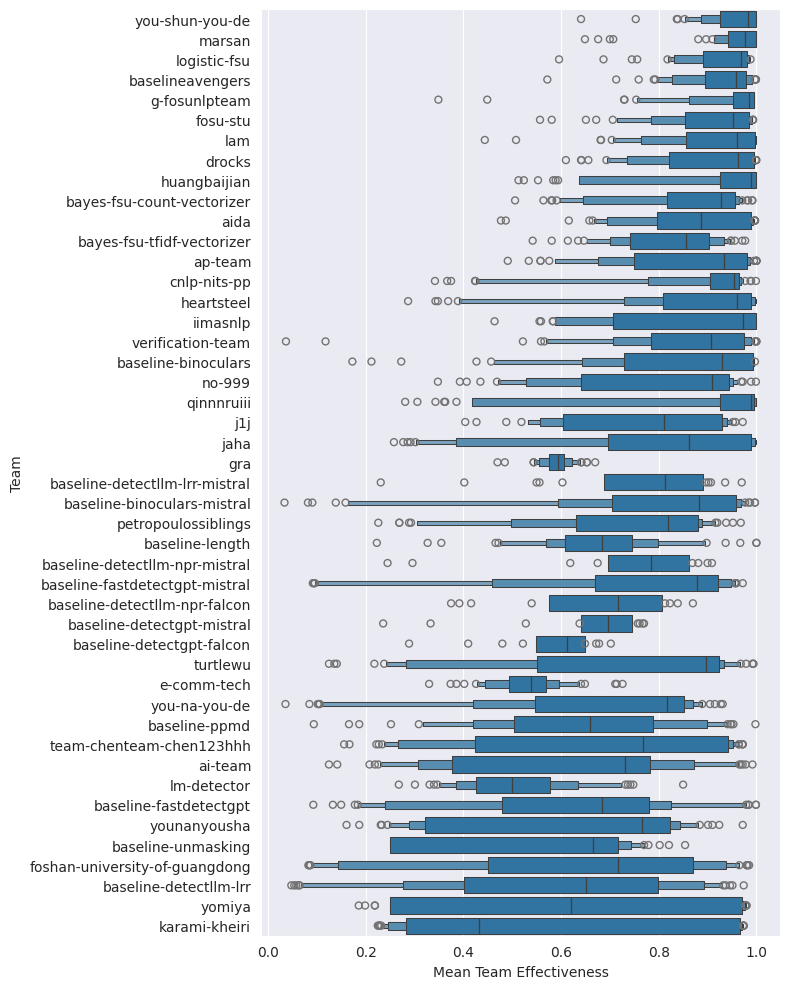

In [15]:
plt.figure(figsize=(8, 10))
sns.boxenplot(data=df, y='team', x='mean', order=df_system_mean_adjusted.reset_index()['team']).set(xlabel='Mean Team Effectiveness', ylabel='Team')
plt.tight_layout()
plt.savefig('../data/eval-figures/team-effectiveness.pdf')
plt.show()

### Dataset Difficulty

In [16]:
df_ds_mean = (1 - df).groupby('dataset').mean().sort_values('mean', ascending=False)
df_ds_mean.to_csv('../data/eval-figures/eloquent-effectiveness.csv')
df_ds_mean

,roc-auc,brier,c@1,f1,f05u,mean
dataset,,,,,,
bigscience-bloomz-7b1-short,0.403553,0.328026,0.455447,0.511342,0.503658,0.440368
text-bison-002-german-short,0.393895,0.328553,0.475289,0.493868,0.496579,0.437658
gpt-4-turbo-preview-german-short,0.399000,0.341947,0.467289,0.494526,0.475816,0.435684
vicgalle-gpt2-open-instruct-v1-short,0.342132,0.293053,0.412289,0.549237,0.573737,0.434053
alpaca-7b-short,0.324658,0.279474,0.399947,0.510158,0.545553,0.411921
...,...,...,...,...,...,...
mistralai-mistral-7b-instruct-v0.2-cross-domain,0.099077,0.108333,0.117333,0.112282,0.103564,0.108103
meta-llama-llama-2-70b-chat-hf-cross-domain,0.094821,0.103205,0.111718,0.116051,0.113846,0.107949
meta-llama-llama-2-70b-chat-hf,0.089457,0.102022,0.107391,0.118457,0.115043,0.106500


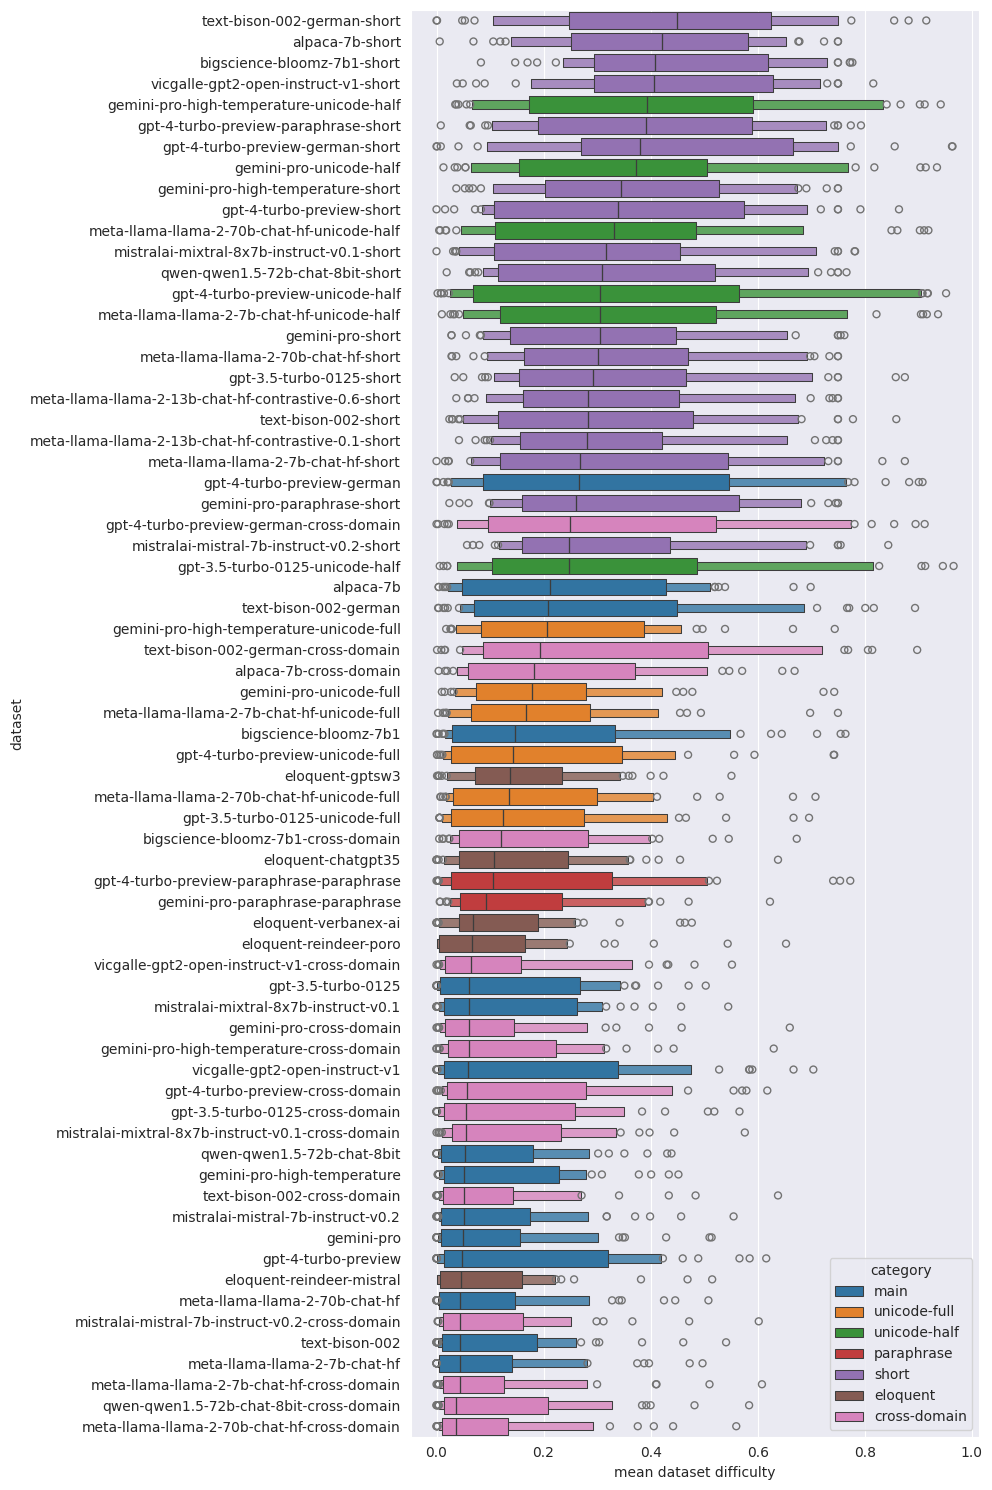

In [17]:
sort_order = df.groupby('dataset').median().sort_values('mean').index
plt.figure(figsize=(10, 15))
sns.boxenplot(data=(1 - df), y='dataset', x='mean', hue='category', order=sort_order).set(xlabel='mean dataset difficulty')
plt.tight_layout()
plt.savefig('../data/eval-figures/dataset-difficulty.pdf')
plt.show()

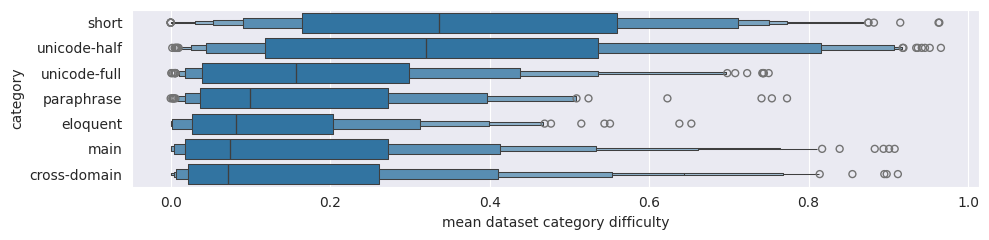

In [18]:
sort_order = df.groupby('category').median().sort_values('mean').index
plt.figure(figsize=(10, 2.5))
sns.boxenplot(data=(1 - df), y='category', x='mean', order=sort_order).set(xlabel='mean dataset category difficulty')
plt.tight_layout()
plt.savefig('../data/eval-figures/dataset-category-difficulty.pdf')
plt.show()

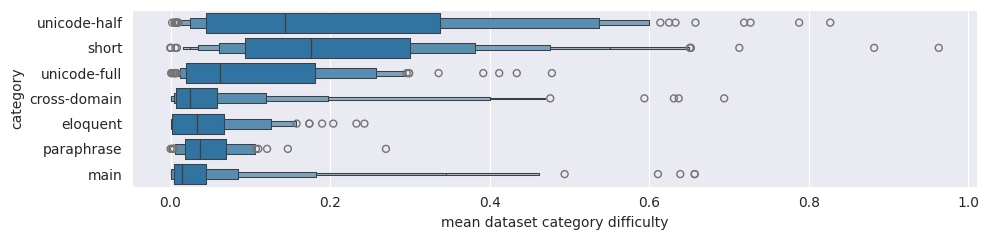

In [19]:
top_idx = df_system_mean_adjusted.iloc[:20].index
df_top = (1 - df).loc[top_idx.get_level_values(0), top_idx.get_level_values(1), :, :]
sort_order = df_top.groupby('category').mean().sort_values('mean', ascending=False).index

plt.figure(figsize=(10, 2.5))
sns.boxenplot(data=df_top, y='category', x='mean', order=sort_order).set(xlabel='mean dataset category difficulty')
plt.tight_layout()
plt.savefig('../data/eval-figures/dataset-category-difficulty-top.pdf')
plt.show()

### ELOQUENT Breaker Effectiveness

In [20]:
df_eloquent_ds = 1 - df.loc[:, :, 'eloquent']

df_eloquent = df_eloquent_ds.sort_values('mean', ascending=False)
df_eloquent.to_csv('../data/eval-figures/eloquent-effectiveness.csv')
df_eloquent

roc-auc  \
team                   system                 dataset                              
lm-detector            detector               eloquent-reindeer-poro       0.583   
baseline-detectllm-lrr baseline-detectllm-lrr eloquent-chatgpt35           0.629   
lm-detector            detector               eloquent-gptsw3              0.461   
e-comm-tech            great-plan             eloquent-reindeer-poro       0.476   
                                              eloquent-reindeer-mistral    0.465   
...                                                                          ...   
huangbaijian           bitter-metaphor        eloquent-verbanex-ai         0.000   
qinnnruiii             tender-couple          eloquent-reindeer-mistral    0.000   
                                              eloquent-reindeer-poro       0.000   
                                              eloquent-verbanex-ai         0.000   
heartsteel             canary-paint           eloquent-chatgpt35           0.000   

                                                                         brier  \
team                   system                 dataset                            
lm-detector            detector               eloquent-reindeer-poro     0.469   
baseline-detectllm-lrr baseline-detectllm-lrr eloquent-chatgpt35         0.356   
lm-detector            detector               eloquent-gptsw3            0.385   
e-comm-tech            great-plan             eloquent-reindeer-poro     0.323   
                                              eloquent-reindeer-mistral  0.314   
...                                                                        ...   
huangbaijian           bitter-metaphor        eloquent-verbanex-ai       0.000   
qinnnruiii             tender-couple          eloquent-reindeer-mistral  0.000   
                                              eloquent-reindeer-poro     0.000   
                                              eloquent-verbanex-ai       0.001   
heartsteel             canary-paint           eloquent-chatgpt35         0.000   

                                                                           c@1  \
team                   system                 dataset                            
lm-detector            detector               eloquent-reindeer-poro     0.656   
baseline-detectllm-lrr baseline-detectllm-lrr eloquent-chatgpt35         0.708   
lm-detector            detector               eloquent-gptsw3            0.542   
e-comm-tech            great-plan             eloquent-reindeer-poro     0.625   
                                              eloquent-reindeer-mistral  0.566   
...                                                                        ...   
huangbaijian           bitter-metaphor        eloquent-verbanex-ai       0.000   
qinnnruiii             tender-couple          eloquent-reindeer-mistral  0.000   
                                              eloquent-reindeer-poro     0.000   
                                              eloquent-verbanex-ai       0.000   
heartsteel             canary-paint           eloquent-chatgpt35         0.000   

                                                                            f1  \
team                   system                 dataset                            
lm-detector            detector               eloquent-reindeer-poro     0.789   
baseline-detectllm-lrr baseline-detectllm-lrr eloquent-chatgpt35         0.739   
lm-detector            detector               eloquent-gptsw3            0.714   
e-comm-tech            great-plan             eloquent-reindeer-poro     0.652   
                                              eloquent-reindeer-mistral  0.636   
...                                                                        ...   
huangbaijian           bitter-metaphor        eloquent-verbanex-ai       0.000   
qinnnruiii             tender-couple          eloquent-reindeer-mistral  0.000   
                          

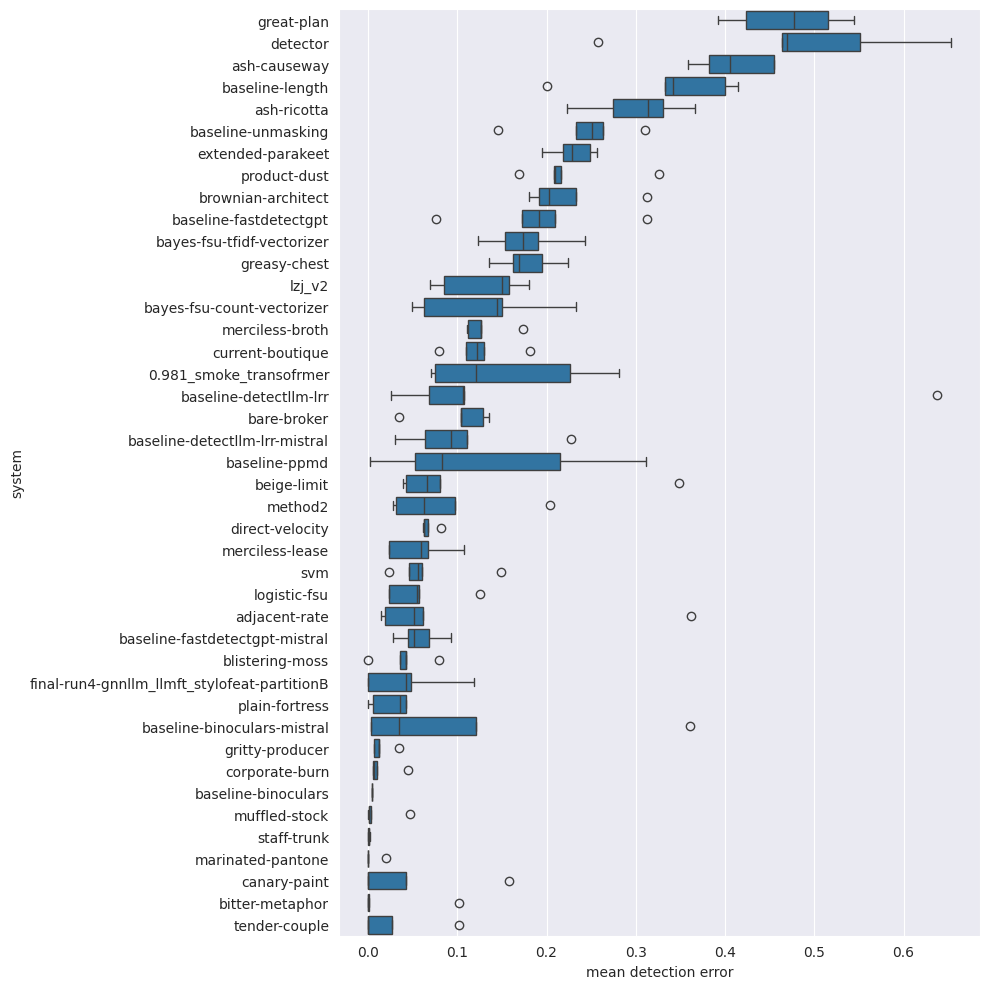

In [21]:
sort_order = df_eloquent_ds.groupby('system').median().sort_values('mean', ascending=False).index

plt.figure(figsize=(10, 10))
sns.boxplot(data=df_eloquent_ds, y='system', x='mean', order=sort_order).set(xlabel='mean detection error')
plt.tight_layout()
plt.savefig('../data/eval-figures/eloquent-system-effectiveness.pdf')
plt.show()

In [22]:
df_eloquent_mean = df_eloquent_ds.groupby('dataset').mean().sort_values('mean', ascending=False)
df_eloquent_mean.to_csv('../data/eval-figures/eloquent-effectiveness-mean.csv')
df_eloquent_mean

,roc-auc,brier,c@1,f1,f05u,mean
dataset,,,,,,
eloquent-gptsw3,0.149286,0.162571,0.179071,0.181929,0.159881,0.166548
eloquent-chatgpt35,0.129810,0.136810,0.161881,0.179857,0.192619,0.160214
eloquent-verbanex-ai,0.098429,0.119167,0.122929,0.142833,0.144667,0.125595
eloquent-reindeer-poro,0.100357,0.113310,0.117452,0.124905,0.126714,0.116571
eloquent-reindeer-mistral,0.084214,0.104405,0.103167,0.104381,0.100643,0.099357


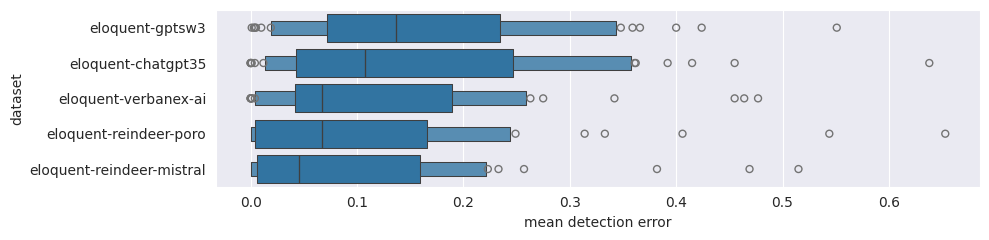

In [23]:
plt.figure(figsize=(10, 2.5))
sns.boxenplot(data=df_eloquent_ds, y='dataset', x='mean', order=df_eloquent_mean.index).set(xlabel='mean detection error')
plt.tight_layout()
plt.savefig('../data/eval-figures/eloquent-effectiveness.pdf')
plt.show()